**Computational Linear Algebra for Large Scale Problems**

**Spectral Clustering (HW_SC)**

| Student Name         | Student ID | Email                    |
|----------------------|------------|--------------------------|
| Mohammadreza Mohammadi | 288654     | s288654@studenti.polito.it |
| Ali Ghasemi          | 289223     | s289223@studenti.polito.it |


# Inroduction

In this project, we have implemented the spectral clustering algorithm for the given dataset. The dataset is a collection of 2D points. The goal is to cluster the points into two groups. The spectral clustering algorithm is a graph-based clustering method. In this method, we first construct a graph from the given dataset. Then, we compute the Laplacian matrix of the graph. Finally, we compute the eigenvectors of the Laplacian matrix and use them to cluster the points. In the following, we explain each step in detail.

## Importing the libraries + Configs

In the following, we import the required libraries and set the configurations.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.csgraph import connected_components
import scipy.sparse.linalg as splinalg
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eig
import sklearn
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN , SpectralClustering, Birch
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

sns.set()
np.set_printoptions(precision=4, floatmode='fixed')

For setting the random seed, we calculate the minimum of the student IDs and use it as the random seed.

In [2]:
rs = min(288654,289223)
np.random.seed(rs)

In [3]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Loading the datasets

In this section, we load the datasets and gain some info about them.

In [4]:
spiral_df = pd.read_csv('spiral.csv', header=None)
spiral_df.columns = ['x', 'y', 'label']
spiral_df.head()

,x,y,label
0,31.95,7.95,3
1,31.15,7.30,3
2,30.45,6.65,3
3,29.70,6.00,3
4,28.90,5.55,3


In [5]:
circle_df = pd.read_csv('circle.csv', header=None)
circle_df.columns = ['x','y']
circle_df.head()

,x,y
0,2.7147,0.81472
1,2.8054,0.94572
2,2.0253,0.20682
3,2.8096,1.03310
4,2.5257,0.79188


The file `Spiral.csv` contains three columns, the third one contains the index of the correct cluster, and the first two columns contain the coordinates of the points. That is why for our analysis, we only use the first two columns.

In [6]:
spiral_x = spiral_df[['x','y']].values

The file `Circle.csv` contains two columns both of which contain the coordinates of the points. That is why for our analysis, we use both columns.

In [7]:
circle_x = circle_df[['x','y']].values

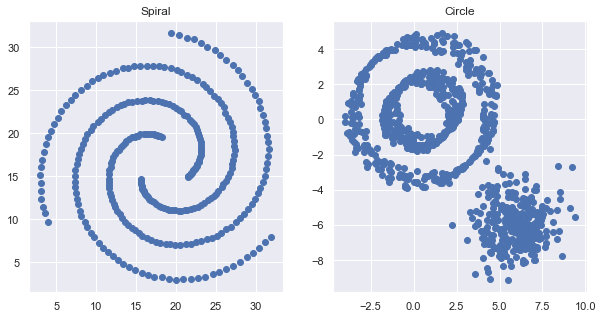

In [8]:
# Plot the data
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(spiral_x[:,0], spiral_x[:,1], cmap='rainbow')
plt.title('Spiral')
plt.subplot(1,2,2)
plt.scatter(circle_x[:,0], circle_x[:,1], cmap='rainbow')
plt.title('Circle')
plt.show()


As mentioned in the homework description as a reminder, given a similarity graph $G$ with $n$ nodes, the similarity matrix $W$ is an $n \times n$ matrix with $W_{ij}$ being the similarity between nodes $i$ and $j$. The similarity matrix is symmetric and non-negative. The diagonal elements are zero.
An edge between two vertices $v_i$ and $v_j$ exists if the similarity between them is either positive or greater than a threshold.

# Task No.1

For the given datasets, we construct the similarity matrix $W$ using the Gaussian kernel. The Gaussian kernel is defined as follows:

$$
s_{ij} = \exp \left( \frac{{\| X_i, X_j \|}^2}{2\sigma^2} \right)
$$

where $X_i$ and $X_j$ are the coordinates of the points $i$ and $j$, respectively, and $\sigma$ is the standard deviation of the Gaussian kernel.

In [9]:
def compute_similarity(X_i, X_j, sigma):
    # Compute the Euclidean distance between the two points.
    distance = np.linalg.norm(X_i - X_j)
    similarity = np.exp(-(distance**2) / (2 * sigma**2))
    return similarity

def compute_similarity_matrix(X, sigma):
    """
    Computing the similarity matrix for a given dataset.
    """
    N = X.shape[0]
    
    # Initializing the similarity matrix.
    similarity_matrix = np.zeros((N, N))
    
    # Computing the similarity matrix.
    for i in range(N):
        for j in range(N):
            if i != j:
                similarity = compute_similarity(X[i], X[j], sigma)
                similarity_matrix[i][j] = similarity
    
    return similarity_matrix

In [10]:
# we set the value of sigma.
sigma = 1

# Compute the similarity matrix for the Spiral dataset.
Spiral_similarity_matrix = compute_similarity_matrix(spiral_x, sigma)

# Compute the similarity matrix for the Circle dataset.
circle_similarity_matrix = compute_similarity_matrix(circle_x, sigma)

In [11]:
# reporting the shape of the similarity matrix

shape_report_df = pd.DataFrame({'Dataset':['Spiral','Circle'], 'Shape':[Spiral_similarity_matrix.shape, circle_similarity_matrix.shape]})
shape_report_df


,Dataset,Shape
0,Spiral,"(312, 312)"
1,Circle,"(900, 900)"


### KNN Graph and Adjacency Matrix

In the following, we construct the k-nearest neighborhood similarity graph and its adjacency matrix W.

To do so, given K and the similarity matrix $W$, we set the similarity between two nodes $i$ and $j$ to zero if the similarity is less than the $K$-th largest similarity of node $i$ and set it to the similarity value if it is greater than the $K$-th largest similarity of node $i$.

It is worth mentioning that if $v_i$ is among the $K$ nearest neighbors of $v_j$, then $v_j$ is not necessarily among the $K$ nearest neighbors of $v_i$. That is why the similarity matrix $W$ is not necessarily symmetric.

In [12]:
def find_k_nearest_neighbors(similarity_matrix, idx, k):
    """
    Finding the list of k-nearest neighbors for a given point.
    NOTE: The similarity matrix is not symmetric.
    """
    # Get the similarity values of the given point with all other points.
    similarity_values = similarity_matrix[idx]
    
    # Sort the similarity values in descending order.
    sorted_indices = np.argsort(similarity_values)[-k:] 
    
    return sorted_indices


# to compute the k-nn similarity matrix
def compute_knn_similarity_matrix(similarity_matrix, k, sigma):
    """
    Building the k-nn adjacency matrix.
    """
    
    # Computing the k-nn similarity matrix.
    knn_similarity_matrix = np.zeros(similarity_matrix.shape)
    for i in range(knn_similarity_matrix.shape[0]):
        k_nearest_neighbors = find_k_nearest_neighbors(similarity_matrix, i, k)
        for j in k_nearest_neighbors:
            
            # NOTE: The similarity matrix is not symmetric.
            k_nearest_neighbors_j = find_k_nearest_neighbors(similarity_matrix, j, k)

            if i != j: # and i in k_nearest_neighbors_j: # TODO: Check if this condition is necessary.

                knn_similarity_matrix[i][j] = similarity_matrix[i][j]
                knn_similarity_matrix[j][i] = similarity_matrix[j][i]

    return knn_similarity_matrix

In [13]:
k = 10
sigma = 1

# Compute KNN for Spiral dataset
spiral_knn_adj_matrix = compute_knn_similarity_matrix(Spiral_similarity_matrix, k, sigma)

# Compute KNN for Circle dataset
circle_knn_adj_matrix = compute_knn_similarity_matrix(circle_similarity_matrix, k, sigma)

In [14]:
# check if the diagonal elements are zero
print('Spiral dataset: ', np.diag(spiral_knn_adj_matrix).sum())
print('Circle dataset: ', np.diag(circle_knn_adj_matrix).sum())

Spiral dataset:  0.0
Circle dataset:  0.0


# Task No.2

To be able to construct the Laplacian matrix, we need to compute the degree matrix $D$. The degree matrix is a diagonal matrix with the degree of each node on the diagonal. The degree of a node is the sum of the similarities between the node and its neighbors.
Then we compute the Laplacian matrix $L$ as follows:

$$
L = D - W
$$

The reason for using the Laplacian matrix in Spectral Clustering is that the eigenvectors of the Laplacian matrix are related to the clusters of the graph. The eigenvectors of the Laplacian matrix are called the Laplacian eigenvectors.

In [15]:
def compute_degree_matrix(adjacency_matrix):
    """
    Compute the degree matrix given an adjacency matrix.
    """

    # Convert to csr_matrix if not already in csr_matrix format
    adjacency_matrix = csr_matrix(adjacency_matrix)

    # Compute the degree vector.
    # the flatten() method returns a copy of the array collapsed into one dimension.
    degree_vector = np.asarray(adjacency_matrix.sum(axis=1)).flatten()

    # Compute the degree matrix.
    degree_matrix = csr_matrix((degree_vector, (range(len(degree_vector)), range(len(degree_vector)))), shape=(len(degree_vector), len(degree_vector)))    
    return degree_matrix

def compute_laplacian_matrix(degree_matrix, adjacency_matrix):
    """
    Compute the Laplacian matrix given an adjacency matrix.
    """
    laplacian_matrix = degree_matrix - adjacency_matrix
    return laplacian_matrix

# Compute Laplacian matrix for Spiral dataset
spiral_degree_matrix = compute_degree_matrix(spiral_knn_adj_matrix)
spiral_laplaican_matrix = compute_laplacian_matrix(spiral_degree_matrix, spiral_knn_adj_matrix)


# Compute Laplacian matrix for Circle dataset
circle_degree_matrix = compute_degree_matrix(circle_knn_adj_matrix)
circle_laplaican_matrix = compute_laplacian_matrix(circle_degree_matrix, circle_knn_adj_matrix)

In [16]:
# reporting the contents of the Laplacian matrix

print('Spiral dataset: \n', spiral_laplaican_matrix)
print('\nCircle dataset: \n', circle_laplaican_matrix)

Spiral dataset: 
 [[ 0.7400 -0.5879 -0.1395 ...  0.0000  0.0000  0.0000]
 [-0.5879  1.3899 -0.6337 ...  0.0000  0.0000  0.0000]
 [-0.1395 -0.6337  1.5639 ...  0.0000  0.0000  0.0000]
 ...
 [ 0.0000  0.0000  0.0000 ...  7.5007 -0.9692 -0.9406]
 [ 0.0000  0.0000  0.0000 ... -0.9692  6.5477 -0.9950]
 [ 0.0000  0.0000  0.0000 ... -0.9406 -0.9950  6.1037]]

Circle dataset: 
 [[ 9.5669 -0.9874  0.0000 ...  0.0000  0.0000  0.0000]
 [-0.9874 10.3987  0.0000 ...  0.0000  0.0000  0.0000]
 [ 0.0000  0.0000 10.2940 ...  0.0000  0.0000  0.0000]
 ...
 [ 0.0000  0.0000  0.0000 ...  8.7779  0.0000  0.0000]
 [ 0.0000  0.0000  0.0000 ...  0.0000 11.6141  0.0000]
 [ 0.0000  0.0000  0.0000 ...  0.0000  0.0000  7.5339]]


# Task No.3

For the purpose of computing the connected components of the graph, we have to compute the eigenvectors of the Laplacian matrix. To do so, we have implemented two functions. The first function (`compute_sorted_eigenvalues_eigenvectors`) computes the eigenvalues and eigenvectors of the Laplacian matrix and sorts them in ascending order. The second function (`compute_connected_components`) computes the connected components of the graph.

We use the `eigsh` function of the `scipy.sparse.linalg` library to compute the eigen values and eigen vectors.

The `which` argument of the `eigsh` function specifies which eigenvalues and eigenvectors to compute. The `which` argument can be one of the following values:

- `which='LM'`: Largest (in magnitude) eigenvalues
- `which='SM'`: Smallest (in magnitude) eigenvalues
- `which='LA'`: Largest (algebraic) eigenvalues
- ... (see the documentation of the `eigsh` function for more details)

The `eigsh` function returns the eigenvalues and eigenvectors in ascending order. That is why we use the `which='SM'` argument to compute the smallest eigenvalues and eigenvectors.

To compute the number connected components, given a threshold $\epsilon$, we count the number of eigenvalues that are less than $\epsilon$ (greater than zero).

In [17]:
def compute_sorted_eigenvalues_eigenvectors (laplacian_matrix, m = None):
    """
    Compute the sorted eigenvalues and eigenvectors of a given matrix.
    """
    # Compute the eigenvalues and eigenvectors.
    eigenvalues, eigenvectors = eigsh(laplacian_matrix, k=5, which='SM')

    # Sort the eigenvalues and eigenvectors in ascending order.
    sorted_indices = np.argsort(eigenvalues)

    # Sort the eigenvalues.
    sorted_eigenvalues = eigenvalues[sorted_indices]

    # Sort the eigenvectors.
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # if is not given, return all eigenvalues and eigenvectors
    if m is None:
        return sorted_eigenvalues, sorted_eigenvectors

    # else return the first m eigenvalues and eigenvectors
    else:
        return sorted_eigenvalues[:m], sorted_eigenvectors[:, :m]


def compute_connected_components(laplacian_matrix, threshold=1.0e-4, m=5):
    """
    Compute the number of connected components given a Laplacian matrix.
    """
    
    eigenvalues, _ = compute_sorted_eigenvalues_eigenvectors(laplacian_matrix, m)  
    connected_components = [x for x in eigenvalues if x < threshold]

    return len(connected_components)


def plot_eigenvalues(sorted_eigenvalues, title,  threshold=1.0e-3):
    """
    To plot the eigenvalues with y-axis in log scale.
    """
    plt.figure(figsize=(10, 5))
    x = range(1, len(sorted_eigenvalues) + 1)
    plt.plot(x, sorted_eigenvalues, 'b-')
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue')
    
    # Write the number of connected components in the plot area with a red dashed line.
    num_connected_components = len([eigen_val for eigen_val in sorted_eigenvalues if eigen_val < threshold])
    plt.text(0.5, 0.5, 'Number of connected components: {}'.format(num_connected_components), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='r')

    plt.axhline(y=threshold, color='r', linestyle='--')
    plt.title(title)
    plt.show()

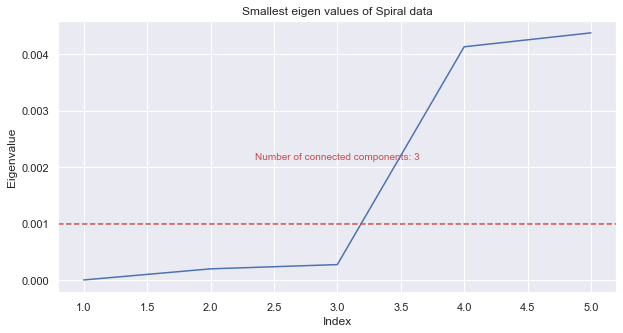

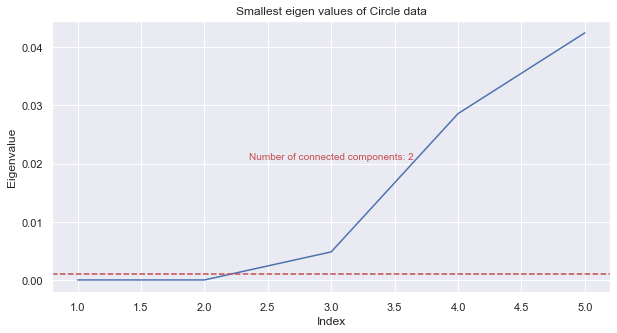

In [18]:
# To compute the connected components

spiral_num_connected_components = compute_connected_components(spiral_laplaican_matrix)
circle_num_connected_components = compute_connected_components(circle_laplaican_matrix)

# plot the eigenvalues
eigenvalues, _ = compute_sorted_eigenvalues_eigenvectors(spiral_laplaican_matrix)
plot_eigenvalues(eigenvalues, "Smallest eigen values of Spiral data", threshold=1e-3)

eigenvalues, _ = compute_sorted_eigenvalues_eigenvectors(circle_laplaican_matrix)
plot_eigenvalues(eigenvalues, "Smallest eigen values of Circle data", threshold=1e-3)

# Task No.4

Considering the plots of the eigenvalues, we could visually find the suitable number of clusters. The number of eigen values before the first big slope is the number of clusters. For both dataset it could be seen that between the third and fourth eigenvalues there is a big slope. So we choose the number of clusters to be 3. The we can denote:
$
M = 3
$

# Task No.5

Using the funtion that we have implemented in the previous task, we compute the M smallest eigenvevtors of the Laplacian matrix. Then we defien the matrix $U$ as follows:

$$
U = \begin{bmatrix}
u_1 & u_2  & u_3
\end{bmatrix}
$$


where $u_i$ is the $i$-th smallest eigenvector of the Laplacian matrix. U belongs to $\mathbb{R}^{N \times M}$.
Then we normalize the rows of the matrix $U$ to have unit length. The normalized matrix is denoted by $U$ as well.

Here we compute the sorted eigenvalues and eigenvectors of the Laplacian matrix for the "Circle" and "Spiral" datasets and then normalizes the eigenvector matrices to have unit length along the rows.

In [19]:
sorted_eigen_val_circle, sorted_eigen_vec_circle = compute_sorted_eigenvalues_eigenvectors(circle_laplaican_matrix, 3)
sorted_eigen_val_spiral, sorted_eigen_vec_spiral = compute_sorted_eigenvalues_eigenvectors(spiral_laplaican_matrix, 3)

In [20]:
# normalize the eigenvectors
def normalize(matrix, axis):
    """
    Normalize a given matrix along a given axis.
    """
    return matrix / np.linalg.norm(matrix, axis=axis, keepdims=True)

spiral_u = normalize(sorted_eigen_vec_spiral, axis=1)
circle_u = normalize(sorted_eigen_vec_circle, axis=1)

# Tasks No.6 and No. 7

Let $y_i$ be the $i$-th row of the matrix $U$. What we are expected to do now, is to cluster the points into three groups. To do so, we use the K-means algorithm. The K-means algorithm is an iterative algorithm. In each iteration, we compute the distance of each point to the centroids of the clusters and assign each point to the cluster with the closest centroid. Then, we update the centroids of the clusters. We repeat this process until the centroids do not change anymore.

In [21]:
from sklearn.cluster import KMeans

def perform_clustering(original_data, u_normalized, n_clusters, random_state):
    """
    Perform clustering on the given data.
    """

    # Perform k-means clustering.
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(u_normalized)

    # Group the data based on the cluster labels.
    clusters = [[] for _ in range(n_clusters)]
    for i in range(original_data.shape[0]):

        # Append the data point to the corresponding cluster.
        clusters[kmeans.labels_[i]].append(original_data[i])
        
    return clusters, kmeans.labels_

# Spiral
spiral_clusters, spiral_clusters_labels = perform_clustering(spiral_x, spiral_u, n_clusters=3, random_state=rs)

# Circle
circle_clusters, circle_clusters_labels = perform_clustering(circle_x, circle_u, n_clusters=3, random_state=rs)


# Task No.8

Plotting the clusters for the "Circle" and "Spiral" datasets

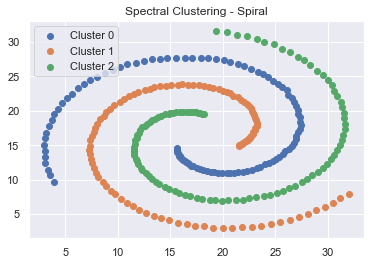

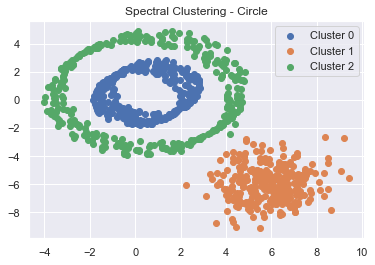

In [22]:
import seaborn as sns

def plot_clusters(data, clusters, title):
    sns.set(style="darkgrid")
    fig, ax = plt.subplots()
    
    for i in range(len(clusters)):
        cluster = np.array(clusters[i])
        ax.scatter(cluster[:, 0], cluster[:, 1], label='Cluster {}'.format(i))
    ax.set_title(title)
    ax.legend()
    plt.show()

# Plot the clusters for Spiral dataset
plot_clusters(spiral_x, spiral_clusters, 'Spectral Clustering - Spiral')

# Plot the clusters for Circle dataset
plot_clusters(circle_x, circle_clusters, 'Spectral Clustering - Circle')


In [23]:
# Evaluate the clustering performance using different metrics

def evaluate_clustering_performance(data, clusters_labels):

    # Compute the silhouette coefficient.
    silhouette_coefficient = silhouette_score(data, clusters_labels, metric='euclidean')

    # Compute the Calinski and Harabasz score.
    calinski_harabasz_score_coefficient = calinski_harabasz_score(data, clusters_labels)

    # Compute the Davies-Bouldin score.
    davies_bouldin_score_coefficient = davies_bouldin_score(data, clusters_labels)

    return silhouette_coefficient, calinski_harabasz_score_coefficient, davies_bouldin_score_coefficient

# Spiral
spiral_silhouette_coefficient, spiral_calinski_harabasz_score_coefficient, spiral_davies_bouldin_score_coefficient = evaluate_clustering_performance(spiral_x, spiral_clusters_labels)

# Circle
circle_silhouette_coefficient, circle_calinski_harabasz_score_coefficient, circle_davies_bouldin_score_coefficient = evaluate_clustering_performance(circle_x, circle_clusters_labels)

In [24]:
# Print resuts as a dataframe

results = pd.DataFrame(columns=['Spiral', 'Circle'], index=['Silhouette Coefficient', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'])
results.index.name = 'Metrics'
results['Spiral'] = [spiral_silhouette_coefficient, spiral_calinski_harabasz_score_coefficient, spiral_davies_bouldin_score_coefficient]
results['Circle'] = [circle_silhouette_coefficient, circle_calinski_harabasz_score_coefficient, circle_davies_bouldin_score_coefficient]
results

,Spiral,Circle
Metrics,,
Silhouette Coefficient,0.001344,0.323268
Calinski-Harabasz Score,5.797852,902.993795
Davies-Bouldin Score,5.882023,82.265848


<b>Task No.9 </b>

In this part, we apply different clustering algorithms on the "Circle" and "Spiral" datasets and compare the results with the results of the Spectral Clustering algorithm. The methods that we are particularly interested in are the K-means, Mean-shift, BIRCH and Agglomerative Clustering algorithms.

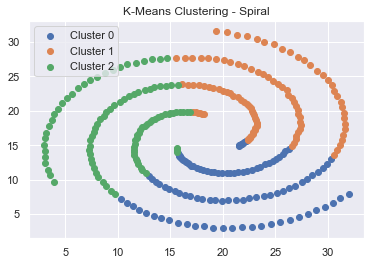

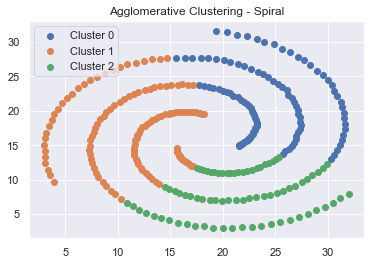

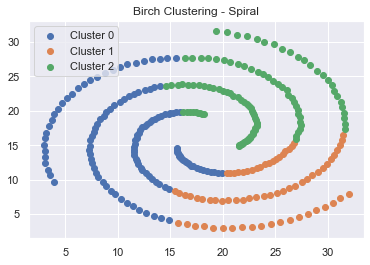

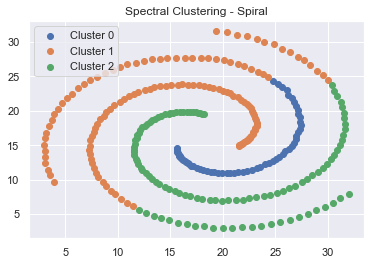

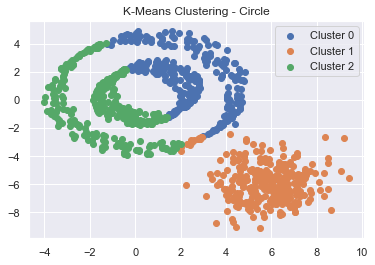

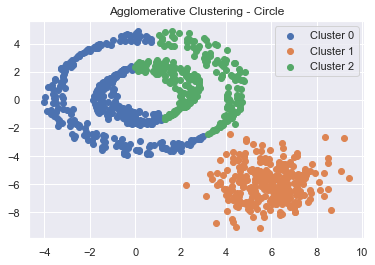

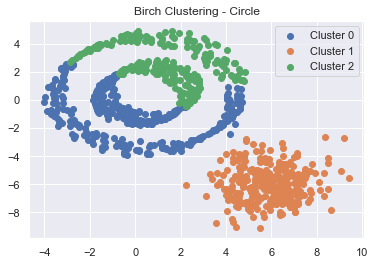

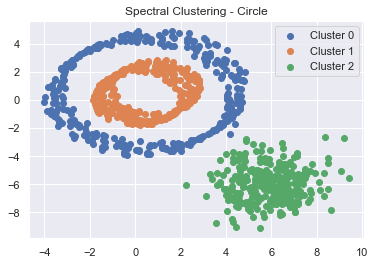

In [25]:
# Apply the clustering methods mentiond above to the datasets

def perform_clustering(data, n_clusters, random_state, clustering_method):

    # Ensure data is in C-contiguous order.
    data = np.ascontiguousarray(data)

    # Perform clustering.
    if clustering_method == AgglomerativeClustering:
        clustering = clustering_method(n_clusters=n_clusters, affinity='euclidean', linkage='ward').fit(data)
    elif clustering_method == Birch:
        clustering = clustering_method(n_clusters=n_clusters).fit(data)
    elif clustering_method == SpectralClustering:
        clustering = clustering_method(n_clusters=n_clusters, random_state=random_state, affinity='nearest_neighbors').fit(data)
    else:
        clustering = clustering_method(n_clusters=n_clusters, random_state=random_state).fit(data)

    # Group the data based on the cluster labels.
    clusters = [[] for _ in range(n_clusters)]
    for i in range(data.shape[0]):

        # Append the data point to the corresponding cluster.
        clusters[clustering.labels_[i]].append(data[i])
        
    return clusters, clustering.labels_



def plot_clusters(data, clusters, title):
    sns.set(style="darkgrid")
    fig, ax = plt.subplots()
    
    for i in range(len(clusters)):
        cluster = np.array(clusters[i])
        # if array is one-dimensional, reshape it to two-dimensional
        if len(cluster.shape) == 1:
            cluster = cluster.reshape(-1, 1)
        
        ax.scatter(cluster[:, 0], cluster[:, 1], label='Cluster {}'.format(i))
    ax.set_title(title)
    ax.legend()
    plt.show()

# Spiral
spiral_kmeans_clusters, spiral_kmeans_clusters_labels = perform_clustering(spiral_x, n_clusters=3, random_state=rs, clustering_method=KMeans)
spiral_agglomerative_clusters, spiral_agglomerative_clusters_labels = perform_clustering(spiral_x, n_clusters=3, random_state=rs, clustering_method=AgglomerativeClustering)
spiral_birch_clusters, spiral_birch_clusters_labels = perform_clustering(spiral_x, n_clusters=3, random_state=rs, clustering_method=Birch)
spiral_spec_clusters, spiral_spec_clusters_labels = perform_clustering(spiral_x, n_clusters=3, random_state=rs, clustering_method=SpectralClustering)

# Circle
circle_kmeans_clusters, circle_kmeans_clusters_labels = perform_clustering(circle_x, n_clusters=3, random_state=rs, clustering_method=KMeans)
circle_agglomerative_clusters, circle_agglomerative_clusters_labels = perform_clustering(circle_x, n_clusters=3, random_state=rs, clustering_method=AgglomerativeClustering)
circle_birch_clusters, circle_birch_clusters_labels = perform_clustering(circle_x, n_clusters=3, random_state=rs, clustering_method=Birch)
circle_spec_clusters, circle_spec_clusters_labels = perform_clustering(circle_x, n_clusters=3, random_state=rs, clustering_method=SpectralClustering)

# Plot the clusters for Spiral dataset
plot_clusters(spiral_x, spiral_kmeans_clusters, 'K-Means Clustering - Spiral')
plot_clusters(spiral_x, spiral_agglomerative_clusters, 'Agglomerative Clustering - Spiral')
plot_clusters(spiral_x, spiral_birch_clusters, 'Birch Clustering - Spiral')
plot_clusters(spiral_x, spiral_spec_clusters, 'Spectral Clustering - Spiral')

# Plot the clusters for Circle dataset
plot_clusters(circle_x, circle_kmeans_clusters, 'K-Means Clustering - Circle')
plot_clusters(circle_x, circle_agglomerative_clusters, 'Agglomerative Clustering - Circle')
plot_clusters(circle_x, circle_birch_clusters, 'Birch Clustering - Circle')
plot_clusters(circle_x, circle_spec_clusters, 'Spectral Clustering - Circle')
